In [169]:
import sys 
import os
import numpy as np
import itertools
from dataclasses import dataclass, replace, field
from matplotlib import pyplot as plt
from typing import Optional, Mapping, Dict, Tuple, TypeVar, Iterable, Sequence, Callable, Iterator, List
from scipy.stats import norm

from rl.markov_process import MarkovProcess, NonTerminal, State
from rl.distribution import Gamma, Distribution, Constant
from rl.chapter9.order_book import OrderBook, DollarsAndShares, PriceSizePairs

In [170]:
@dataclass(frozen=True)
class MarketState:
    Inventory: int
    PnL: float
    S_t: float
    t: float
    hits: float
    lifts: float
    BidPrice: float
    AskPrice: float
        
    def spread(self):
        return self.AskPrice - self.BidPrice
    
        
        
'''
Because we have a fixed known optimal policy, we can essentially just model this
as a Markov Process, and keep the rewards as essentially part of the "state" of the 
model.
'''



class MarketMakerOptPolicy(MarkovProcess[MarketState]):
    c: float
    k: float
    sig: float
    dt: float
    T: int
    gamma: float
    

    
    def __init__(self, c, k, sig, dt, T, gamma):
        self.c = c
        self.k = k
        self.sig = sig
        self.dt = dt
        self.T = T
        self.gamma = gamma
        
        super().__init__()
        
        
    def transition(self, state: NonTerminal[MarketState]) -> Distribution[State[MarketState]]:
        '''
        In order to get next state, first need to calculate optimal actions, which
        are functions 
        '''
        
    
        opt_bid_spread = (2*state.state.Inventory + 1)
        opt_bid_spread *= self.gamma*(self.sig**2)*(T-state.state.t)
        opt_bid_spread /= 2
        opt_bid_spread += (1/self.gamma)*np.log(1 + (self.gamma/self.k))
    
    
        opt_ask_spread = (1-2*state.state.Inventory)
        opt_ask_spread *= self.gamma*(self.sig**2)*(T-state.state.t)
        opt_ask_spread /= 2
        opt_ask_spread += (1/self.gamma)*np.log(1 + (self.gamma/self.k))
        
        
        opt_ask_price = opt_ask_spread  + state.state.S_t
        opt_bid_price = state.state.S_t - opt_bid_spread  
        
        
        
        rnd_ask = np.random.uniform(0,1)
        rnd_bid = np.random.uniform(0,1)
        rnd_price = np.random.uniform(0,1)
        
        prob_ask = self.c*np.exp(-self.k*opt_ask_spread)*self.dt
        prob_bid = self.c*np.exp(-self.k*opt_bid_spread)*self.dt
        prob_price = 0.5
        
        new_inventory = state.state.Inventory
        new_t = state.state.t + dt
        new_PnL = state.state.PnL
        new_S_t = state.state.S_t 
        new_hits = state.state.hits
        new_lifts = state.state.lifts
        new_BP = opt_bid_price
        new_AP = opt_ask_price
        
        
        if(rnd_ask < prob_ask):
            new_inventory -= 1
            new_PnL += opt_ask_price
            new_hits += 1
            
        if(rnd_bid < prob_bid):
            new_inventory += 1
            new_PnL -= opt_bid_price
            new_lifts += 1
            
        if(rnd_price < prob_price):
            new_S_t += self.sig*np.sqrt(self.dt)
        else:
            new_S_t -= self.sig*np.sqrt(self.dt)
            
            
        new_state = MarketState(new_inventory, new_PnL, new_S_t, new_t,
                               new_hits, new_lifts, new_BP, new_AP)
        return Constant(NonTerminal(new_state))


In [171]:
S_0 = 100
c = 140
k = 1.5
sigma = 2.0
dt = 0.005
T = 1
gamma = 0.1

start_market = MarketState(0,0,S_0,0, 0,0,0,0)
start_state_distribution = Constant(NonTerminal(start_market))

MarketMakerOptMP = MarketMakerOptPolicy(c, k, sigma, dt, T, gamma)



In [172]:
def order_book_traces(num_traces, MarketMP) -> np.ndarray:
    timesteps = int(T/dt)
    
    spread = np.zeros((num_traces, timesteps))
    PnL = np.zeros((num_traces,timesteps))
    Inventory = np.zeros((num_traces,timesteps))
    OBMidPrice = np.zeros((num_traces,timesteps))
    BidPrice = np.zeros((num_traces,timesteps))
    AskPrice = np.zeros((num_traces,timesteps))
    Hits = np.zeros((num_traces,timesteps))
    Lifts = np.zeros((num_traces,timesteps))
    
    
    
    for i in range(num_traces):
        for s in itertools.islice(MarketMP.simulate(start_state_distribution), timesteps):
            metric = s.state
            idx = round(metric.t/dt)
            spread[i, idx] = metric.spread()
            PnL[i,idx] = metric.PnL
            Inventory[i,idx] = metric.Inventory
            OBMidPrice[i,idx] = metric.S_t
            BidPrice[i,idx] = metric.BidPrice
            AskPrice[i,idx] = metric.AskPrice
            Hits[i,idx] = metric.hits
            Lifts[i,idx] = metric.lifts
        
    return spread,PnL,Inventory,OBMidPrice,BidPrice,AskPrice,Hits,Lifts


    
    
    

In [173]:
opt_spread, opt_PnL, optInventory, opt_mid, opt_bid, opt_ask, opt_hits, opt_lifts = order_book_traces(10000, 
                                                                                            MarketMakerOptMP)





In [174]:
#First find the average spread over all time steps and for all traces to use as the next "policy"

avg_spread = np.mean(opt_spread)
print(avg_spread)

1.4853065706376674


In [175]:
class MarketMakerNaivePolicy(MarkovProcess[MarketState]):
    c: float
    k: float
    sig: float
    dt: float
    T: int
    gamma: float
    

    
    def __init__(self, c, k, sig, dt, T, gamma):
        self.c = c
        self.k = k
        self.sig = sig
        self.dt = dt
        self.T = T
        self.gamma = gamma
        
        super().__init__()
        
        
    def transition(self, state: NonTerminal[MarketState]) -> Distribution[State[MarketState]]:
        
        spread = avg_spread
            
        naive_ask_price = state.state.S_t + (avg_spread/2)
        naive_bid_price = state.state.S_t - (avg_spread/2)
        
        naive_ask_spread = avg_spread/2
        naive_bid_spread = avg_spread/2
        
        
        
        rnd_ask = np.random.uniform(0,1)
        rnd_bid = np.random.uniform(0,1)
        rnd_price = np.random.uniform(0,1)
        
        prob_ask = self.c*np.exp(-self.k*naive_ask_spread)*self.dt
        prob_bid = self.c*np.exp(-self.k*naive_bid_spread)*self.dt
        prob_price = 0.5
        
        new_inventory = state.state.Inventory
        new_t = state.state.t + dt
        new_PnL = state.state.PnL
        new_S_t = state.state.S_t 
        new_hits = state.state.hits
        new_lifts = state.state.lifts
        new_BP = naive_bid_price
        new_AP = naive_ask_price
        
        
        if(rnd_ask < prob_ask):
            new_inventory -= 1
            new_PnL += naive_ask_price
            new_hits += 1
            
        if(rnd_bid < prob_bid):
            new_inventory += 1
            new_PnL -= naive_bid_price
            new_lifts += 1
             
        if(rnd_price < prob_price):
            new_S_t += self.sig*np.sqrt(self.dt)
        else:
            new_S_t -= self.sig*np.sqrt(self.dt)
            
            
        new_state = MarketState(new_inventory, new_PnL, new_S_t, new_t,
                               new_hits, new_lifts, new_BP, new_AP)
        return Constant(NonTerminal(new_state))

In [176]:
S_0 = 100
c = 140
k = 1.5
sigma = 2.0
dt = 0.005
T = 1
gamma = 0.1

start_market = MarketState(0,0,S_0,0, 0,0,0,0)
start_state_distribution = Constant(NonTerminal(start_market))

MarketMakerNaiveMP = MarketMakerNaivePolicy(c, k, sigma, dt, T, gamma)


In [177]:
n_spread, n_PnL, nInventory, n_mid, n_bid, n_ask, n_hits, n_lifts = order_book_traces(10000, 
                                                                                        MarketMakerNaiveMP)

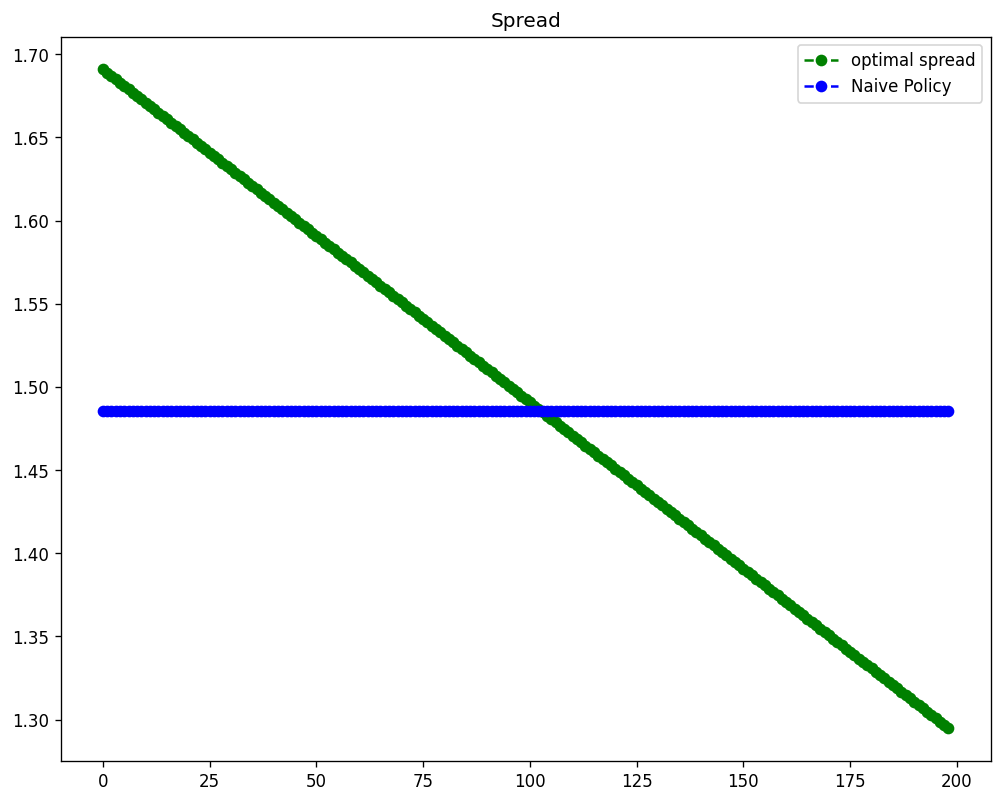

In [178]:
opt_spread_exp = np.average(opt_spread, axis = 0)
n_spread_exp = np.average(n_spread, axis = 0)
plt.plot(opt_spread_exp[1:], 'go--', label = "optimal spread")
plt.plot(n_spread_exp[1:], 'bo--', label = "Naive Policy")
plt.title("Spread")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)

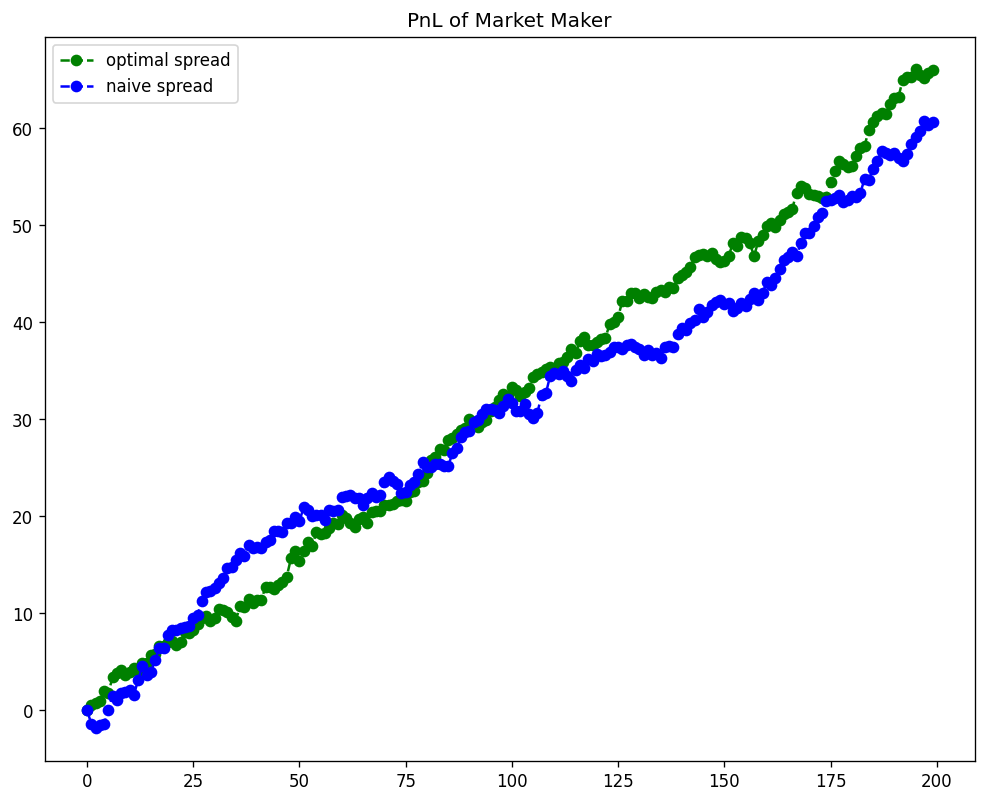

In [179]:
opt_PnL_exp = np.average(opt_PnL, axis = 0)
n_PnL_exp = np.average(n_PnL, axis = 0)
plt.plot(opt_PnL_exp, 'go--', label = "optimal spread")
plt.plot(n_PnL_exp, 'bo--', label = "naive spread")
plt.title("PnL of Market Maker")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)

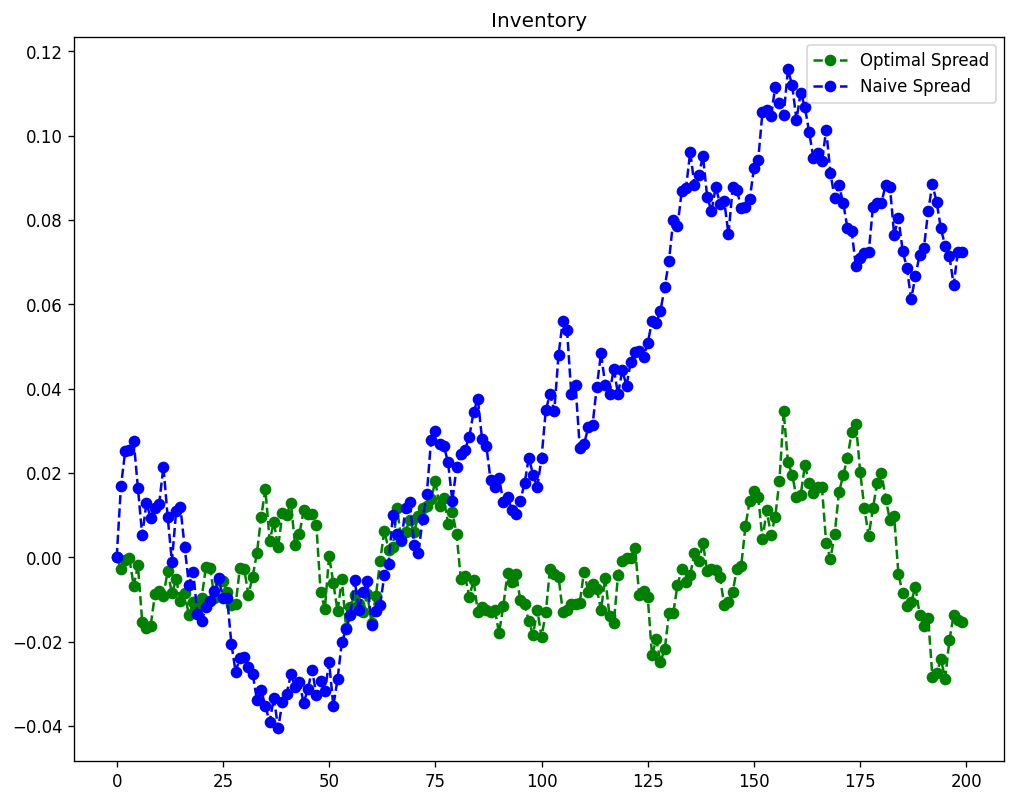

In [180]:
opt_inv_exp = np.average(optInventory, axis = 0)
n_inv_exp = np.average(nInventory, axis = 0)
plt.plot(opt_inv_exp, 'go--', label = "Optimal Spread")
plt.plot(n_inv_exp, 'bo--', label = "Naive Spread")
plt.legend()
plt.title("Inventory")
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)

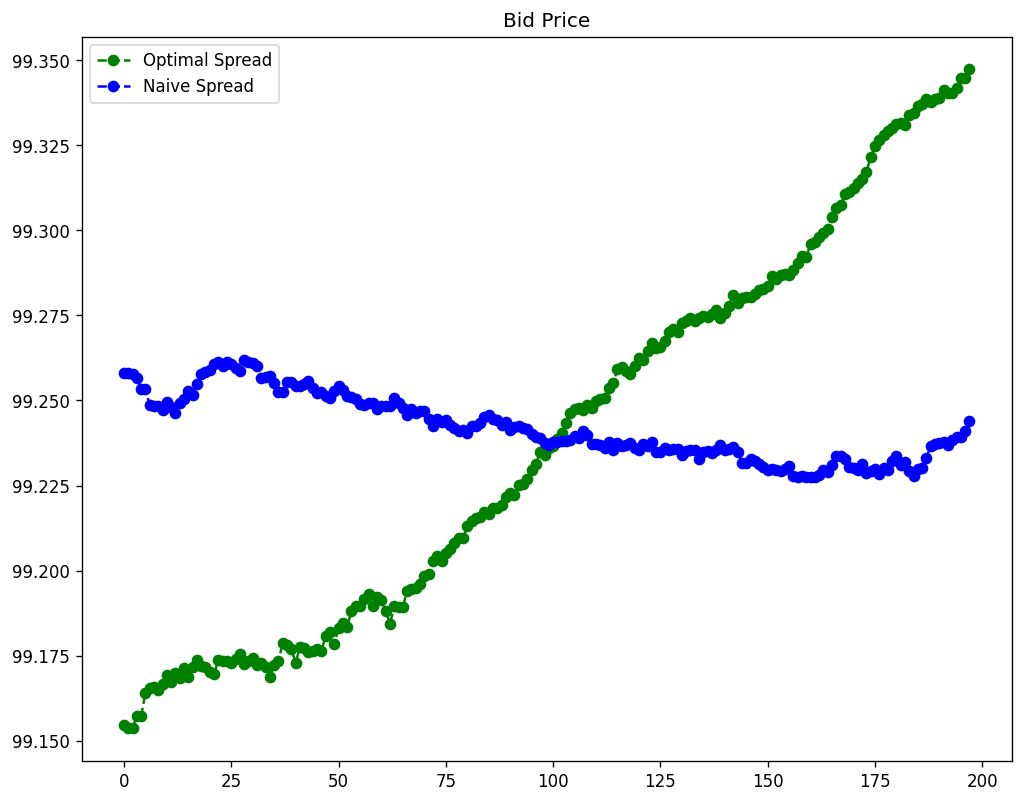

In [181]:
opt_bid_exp = np.average(opt_bid, axis =0)
n_bid_exp = np.average(n_bid, axis = 0)
plt.plot(opt_bid_exp[2:], 'go--', label = "Optimal Spread")
plt.plot(n_bid_exp[2:], 'bo--', label = "Naive Spread")
plt.legend()
plt.title("Bid Price")
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)

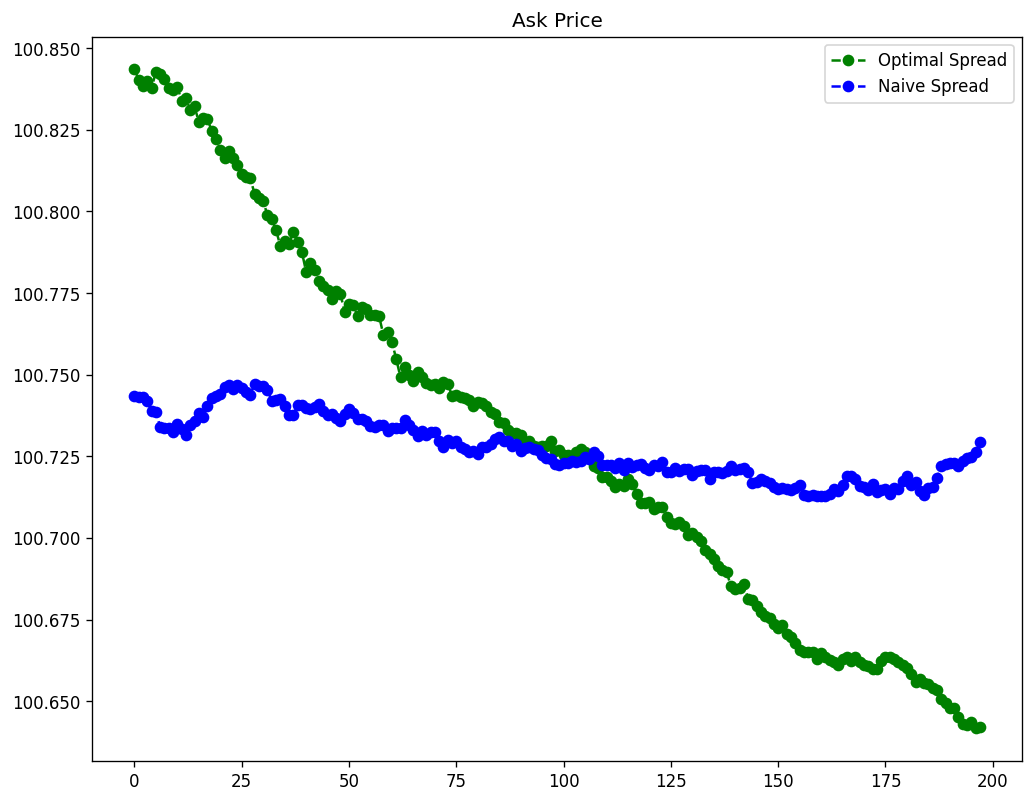

In [182]:
opt_ask_exp = np.average(opt_ask, axis = 0)
b_ask_exp = np.average(n_ask, axis=0)
plt.plot(opt_ask_exp[2:], 'go--', label = "Optimal Spread")
plt.plot(b_ask_exp[2:], 'bo--', label = "Naive Spread")
plt.legend()
plt.title("Ask Price")
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)

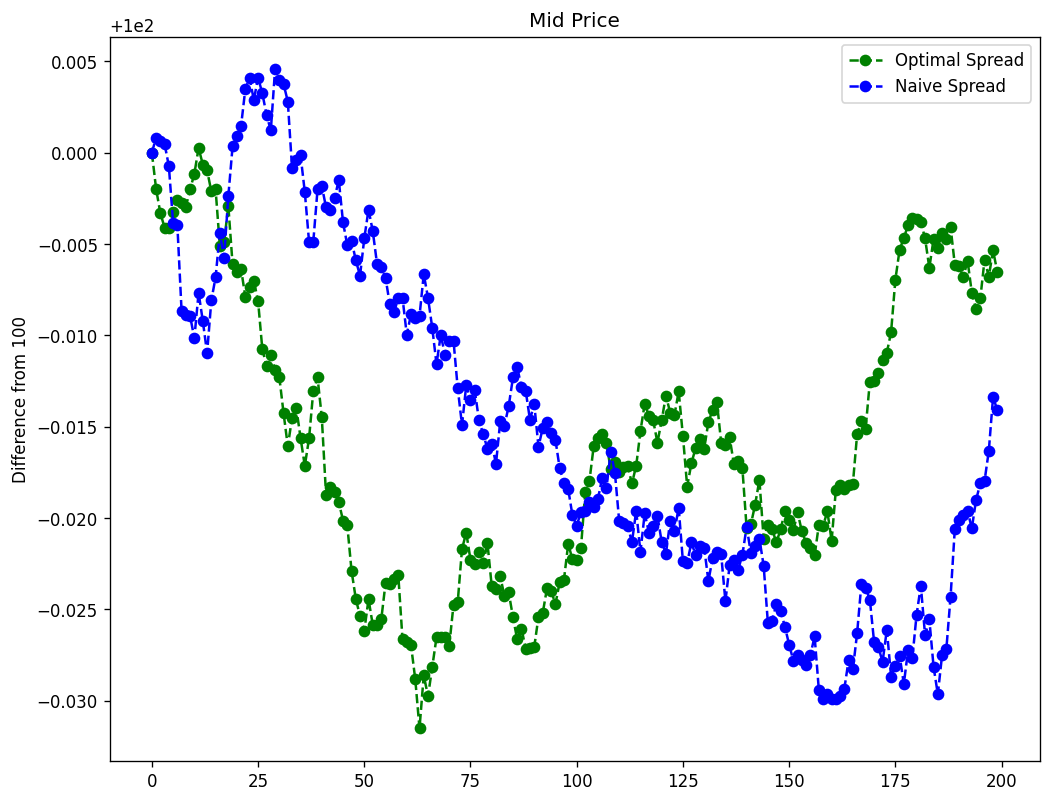

In [183]:
opt_mid_exp = np.average(opt_mid, axis = 0)
n_mid_exp = np.average(n_mid, axis = 0)
plt.plot(opt_mid_exp, 'go--', label = "Optimal Spread")
plt.plot(n_mid_exp, 'bo--', label = "Naive Spread")
plt.legend()
plt.title("Mid Price")
plt.ylabel("Difference from 100")
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)

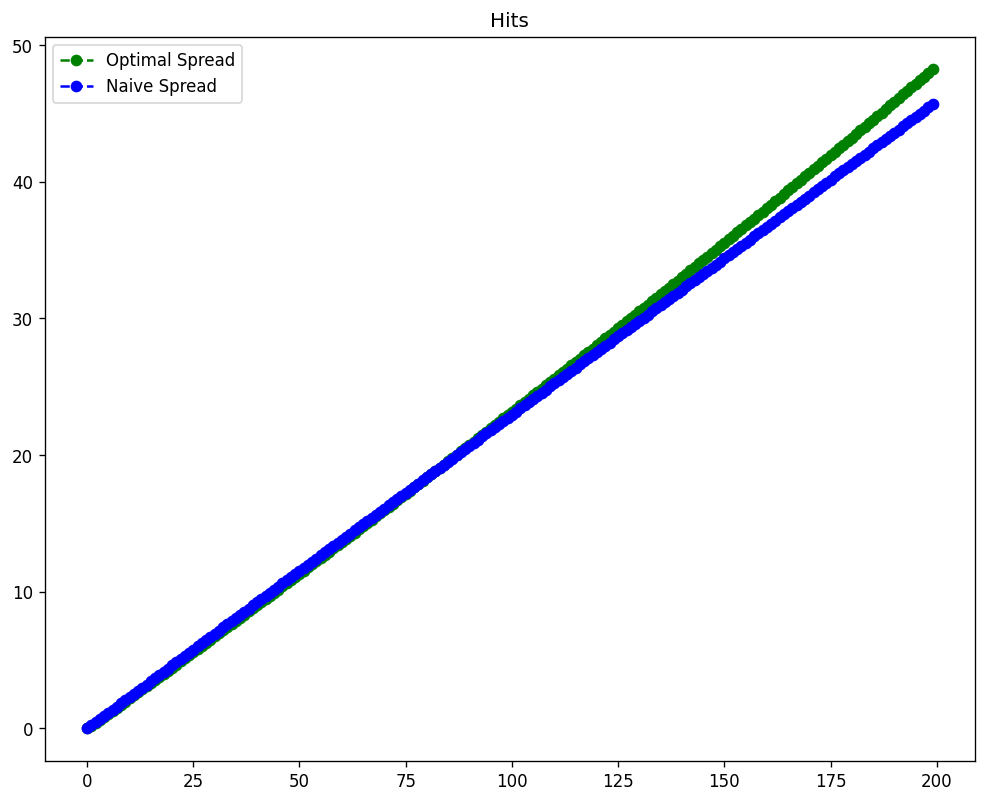

In [184]:
opt_hits_exp = np.average(opt_hits, axis =0)
n_hits_exp = np.average(n_hits, axis = 0)
plt.plot(opt_hits_exp, 'go--', label = "Optimal Spread")
plt.plot(n_hits_exp, 'bo--', label = "Naive Spread")
plt.legend()
plt.title("Hits")
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)

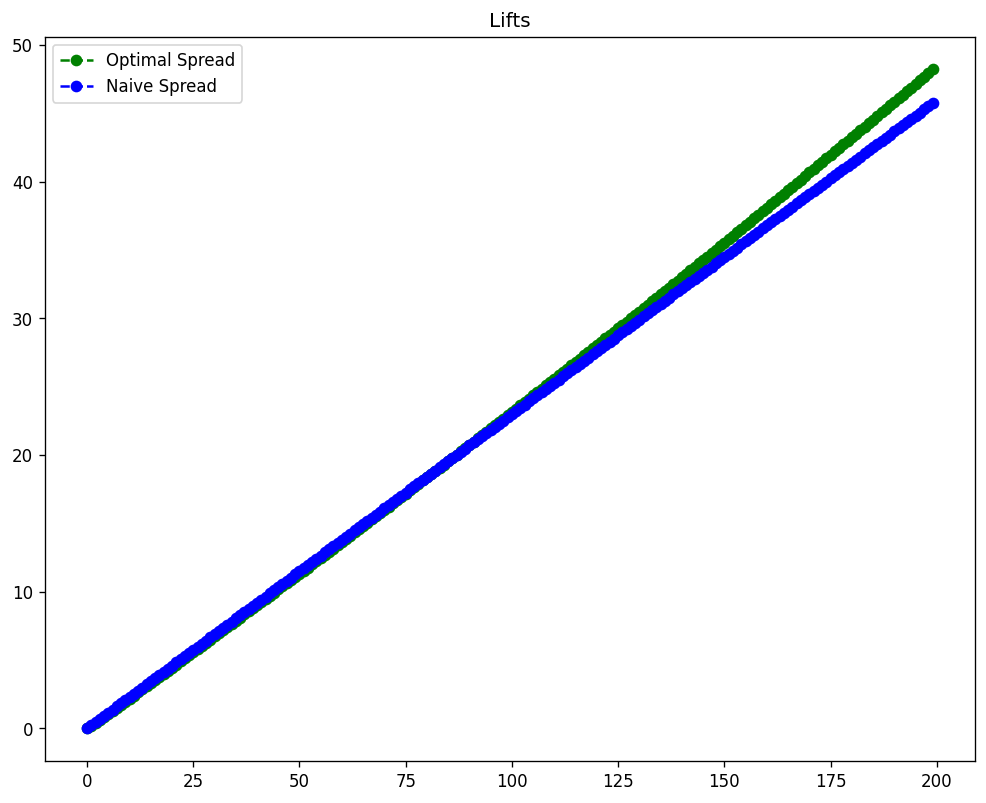

In [185]:
opt_lifts_exp = np.average(opt_lifts, axis = 0)
n_lifts_exp = np.average(n_lifts, axis =0)
plt.plot(opt_lifts_exp, 'go--', label = "Optimal Spread")
plt.plot(n_lifts_exp, 'bo--', label = "Naive Spread")
plt.legend()
plt.title("Lifts")
fig = plt.gcf()
fig.set_size_inches(10,8)
fig.set_dpi(120)